In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DateType, FloatType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from scipy.stats import linregress
from functools import reduce
from pyspark.sql.functions import udf, to_date, rank, month, year, dayofmonth, collect_list
from pyspark.ml.linalg import Vectors
from utils.load_data import *
from utils.remove_folder import *
import datetime
from pyspark.sql.functions import col, lit
from pyspark.sql import DataFrame


In [2]:
#sparkSession 
spark = SparkSession.builder \
      .master("local[1]") \
      .appName("PySpark project") \
      .getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


In [3]:
#fit the kmeans model and make predictions for each group
def fit_kmeans(df):
    model = kmeans.fit(df)
    return model.transform(df)

#this method groups the data by year and month, applies kmeans, and returns a pyspark dataframe
def get_month_clust(df_features):
    clusters_list = []
    for (year, month), group_df in df_features.toPandas().groupby(['Year', 'Month']):
         
        group_spark_df = spark.createDataFrame(group_df)
        #apply KMeans
        predictions_df = fit_kmeans(group_spark_df)
        #add the 'Year' and 'Month' columns with the corresponding group values
        predictions_df = predictions_df.withColumn("Year", lit(year))
        predictions_df = predictions_df.withColumn("Month", lit(month))
        clusters_list.append(predictions_df)
    
    #combine all the cluster dataframes together
    return reduce(DataFrame.unionAll, clusters_list)


In [4]:
#udf to calculate the trendline coefficient
def trendline_coef(dates, cases):
    if not dates or not cases or len(dates) < 2:
        return None
    # Perform linear regression
    reg, intercept, r_value, p_value, std_err = linregress(dates, cases)
    return float(reg)

trendline_coef_udf = udf(trendline_coef, FloatType())

## QUESTION 3 : Considering the 50 most affected states calculated on a monthly basis according to the trendline coefficient, for each month in the dataset, apply the clustering algorithm K-means [1, 2] with K= 4. Determine the states (or nations) that are part of each cluster. Each cluster should group the states that have a similar pattern of daily increases in confirmed cases


In [5]:
#load clean Data
data_path = "data"  
df = load_csv_from_cleaned_folder(spark, data_path)
df.show(5)


+--------------+--------------+-----------+---------+--------+---------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+----

Step 1 : Create Pivot the dataframe to get the date in  a single col

In [6]:

#remove the / in the non date col
df = df.withColumnRenamed("Province/State", "Province_State").withColumnRenamed("Country/Region", "Country_Region")

#list of columns that are not dates
non_date_cols = ['Province_State', 'Country_Region', 'CountryCode', 'Continent', 'Lat', 'Long']

#list of date columns
date_cols = [col for col in df.columns if col not in non_date_cols]

#stack the date columns to long format
stack_expr = "stack(" + str(len(date_cols)) + ", " + \
    ", ".join(["'" + c + "', `" + c + "`" for c in date_cols]) + ") as (Date, Confirmed)"
df_pivot = df.selectExpr(*non_date_cols, stack_expr)

#convert Date column to a proper date format
df_pivot = df_pivot.withColumn("Date", to_date("Date", "MM/dd/yy"))

df_pivot.show(5)

+--------------+--------------+-----------+---------+--------+---------+----------+---------+
|Province_State|Country_Region|CountryCode|Continent|     Lat|     Long|      Date|Confirmed|
+--------------+--------------+-----------+---------+--------+---------+----------+---------+
|   Afghanistan|   Afghanistan|         AF|     Asia|33.93911|67.709953|2020-01-22|        0|
|   Afghanistan|   Afghanistan|         AF|     Asia|33.93911|67.709953|2020-01-23|        0|
|   Afghanistan|   Afghanistan|         AF|     Asia|33.93911|67.709953|2020-01-24|        0|
|   Afghanistan|   Afghanistan|         AF|     Asia|33.93911|67.709953|2020-01-25|        0|
|   Afghanistan|   Afghanistan|         AF|     Asia|33.93911|67.709953|2020-01-26|        0|
+--------------+--------------+-----------+---------+--------+---------+----------+---------+
only showing top 5 rows



Step 2 : 
- Calculate the monthly trendline coefficient
- Rank provinces/states based on the trendline coefficient
- Select the top 50 most affected provinces/states for each month



In [7]:

#group by Province/State, Country/Region, and month, and calculate the trendline coef
df_grouped = df_pivot.withColumn('Month', month('Date'))\
                    .withColumn('Year', year('Date'))\
                    .withColumn('Day', dayofmonth('Date'))\
                    .groupBy('Province_State', 'Country_Region', 'CountryCode', 'Continent', 'Lat', 'Long', 'Year', 'Month')\
                    .agg(collect_list('Day').alias('Days'), collect_list('Confirmed').alias('Cases'))


df_trendline = df_grouped.withColumn('TrendlineCoef', trendline_coef_udf('Days', 'Cases'))

windowSpec = Window.partitionBy('Year', 'Month').orderBy(col('TrendlineCoef').desc())

#rank based on the trendline coef to get the top 50 
df_ranked = df_trendline.withColumn('Rank', rank().over(windowSpec))
df_top50 = df_ranked.filter(col('Rank') <= 50)

df_top50.show(100)

+--------------------+--------------------+-----------+---------+---------+----------+----+-----+--------------------+--------------------+-------------+----+
|      Province_State|      Country_Region|CountryCode|Continent|      Lat|      Long|Year|Month|                Days|               Cases|TrendlineCoef|Rank|
+--------------------+--------------------+-----------+---------+---------+----------+----+-----+--------------------+--------------------+-------------+----+
|               Hubei|               China|         CN|     Asia|  30.9756|  112.2707|2020|    1|[22, 23, 24, 25, ...|[444, 444, 549, 7...|    625.69696|   1|
|            Zhejiang|               China|         CN|     Asia|  29.1832|  120.0934|2020|    1|[22, 23, 24, 25, ...|[10, 27, 43, 62, ...|    55.642426|   2|
|           Guangdong|               China|         CN|     Asia|  23.3417|  113.4244|2020|    1|[22, 23, 24, 25, ...|[26, 32, 53, 78, ...|         45.4|   3|
|               Henan|               China|   

Step 3 : Kmeans clustering for each month

In [8]:

#ensure trendline coef is the correct data type
df_top50 = df_top50.withColumn("TrendlineCoef", df_top50["TrendlineCoef"].cast("float"))

#assemble features into a vector
vecAssembler = VectorAssembler(inputCols=["TrendlineCoef"], outputCol="features")
df_features = vecAssembler.transform(df_top50)

#create a UDF to assign clusters
kmeans = KMeans(k=4, seed=1, featuresCol="features", predictionCol="Cluster")


#compute
df_with_clusters = get_month_clust(df_features)

df_with_clusters.show()


/opt/conda/envs/vscode_pyspark/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+--------------+--------------+-----------+---------+-------+--------+----+-----+--------------------+--------------------+------------------+----+--------------------+-------+
|Province_State|Country_Region|CountryCode|Continent|    Lat|    Long|Year|Month|                Days|               Cases|     TrendlineCoef|Rank|            features|Cluster|
+--------------+--------------+-----------+---------+-------+--------+----+-----+--------------------+--------------------+------------------+----+--------------------+-------+
|         Hubei|         China|         CN|     Asia|30.9756|112.2707|2020|    1|[22, 23, 24, 25, ...|[444, 444, 549, 7...| 625.6969604492188|   1| [625.6969604492188]|      0|
|      Zhejiang|         China|         CN|     Asia|29.1832|120.0934|2020|    1|[22, 23, 24, 25, ...|[10, 27, 43, 62, ...|55.642425537109375|   2|[55.642425537109375]|      2|
|     Guangdong|         China|         CN|     Asia|23.3417|113.4244|2020|    1|[22, 23, 24, 25, ...|[26, 32, 53, 

In [9]:
#select the wanted columns
df_with_clusters = df_with_clusters.select("Province_State", "Country_Region", "Lat", "Long", "Month", "TrendlineCoef", "Cluster")
df_with_clusters.show(1000)

+--------------------+--------------------+----------+----------+-----+-------------------+-------+
|      Province_State|      Country_Region|       Lat|      Long|Month|      TrendlineCoef|Cluster|
+--------------------+--------------------+----------+----------+-----+-------------------+-------+
|               Hubei|               China|   30.9756|  112.2707|    1|  625.6969604492188|      0|
|            Zhejiang|               China|   29.1832|  120.0934|    1| 55.642425537109375|      2|
|           Guangdong|               China|   23.3417|  113.4244|    1| 45.400001525878906|      2|
|               Henan|               China|   37.8957|  114.9042|    1|   39.2242431640625|      2|
|               Hunan|               China|   27.6104|  111.7088|    1|  37.23636245727539|      2|
|               Anhui|               China|   31.8257|  117.2264|    1|  26.40606117248535|      3|
|             Jiangxi|               China|    27.614|  115.7221|    1|  24.18787956237793|      3|


In [10]:

#Save the result
rm_dir("query_results", "*_query3")
#write result_df to csv
today = datetime.date.today().strftime("%Y%m%d")
file_path = os.path.join("query_results", f"{today}_query3")
df_with_clusters.coalesce(1).write.format('com.databricks.spark.csv').mode('overwrite').option("header", "true").save(file_path)

print(f"Saved : {file_path}")


Removed old directory: query_results/20231118_query3
Saved : query_results/20231118_query3


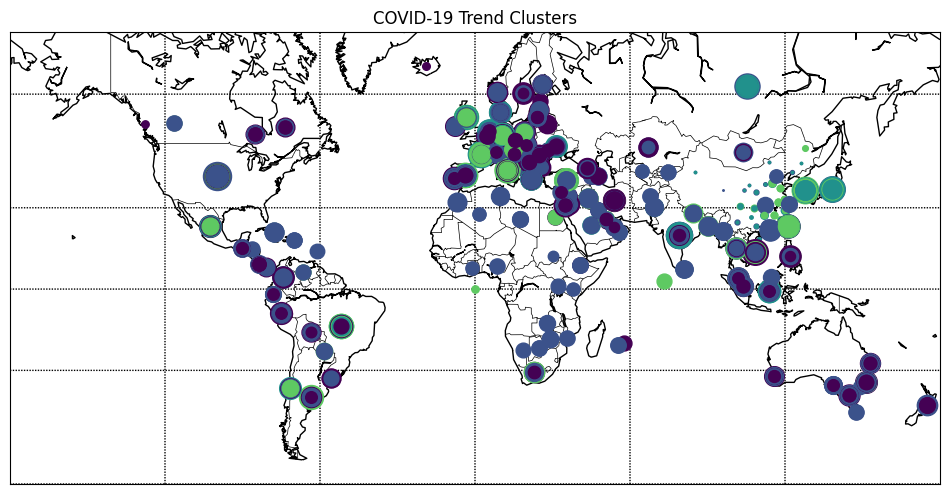

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import numpy as np

pandas_df = df_with_clusters.toPandas()


# Create the frame world map
plt.figure(figsize=(12, 8))
m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(-90., 91., 30.))
m.drawmeridians(np.arange(-180., 181., 60.))

# Dynamic size mark compute
pandas_df['NormalizedSize'] = pandas_df['TrendlineCoef'].apply(lambda x: np.log1p(abs(x)) * 3)

# plot each mark
for index, row in pandas_df.iterrows():
    x, y = m(row['Long'], row['Lat'])
    size = row['NormalizedSize']
    m.plot(x, y, marker='o', color=plt.cm.viridis(row['Cluster'] / 4), markersize=size/2)


plt.title('COVID-19 Trend Clusters')
plt.show()
